In [14]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import json
from datetime import datetime
import pymongo


In [18]:
TICKER = input()

DIA


In [21]:
#Adjusted Values. DataFrame Construction.

data = pd.DataFrame()

data[TICKER] = wb.DataReader(TICKER, data_source='yahoo', start='2000-1-1')['Adj Close']

data[TICKER].head()

Date
2000-01-03    74.023376
2000-01-04    71.587883
2000-01-05    72.515244
2000-01-06    72.882034
2000-01-07    75.327766
Name: DIA, dtype: float64

In [22]:
# #Preview Data

df = data[TICKER].to_frame()
df.head()

,DIA
Date,
2000-01-03,74.023376
2000-01-04,71.587883
2000-01-05,72.515244
2000-01-06,72.882034
2000-01-07,75.327766


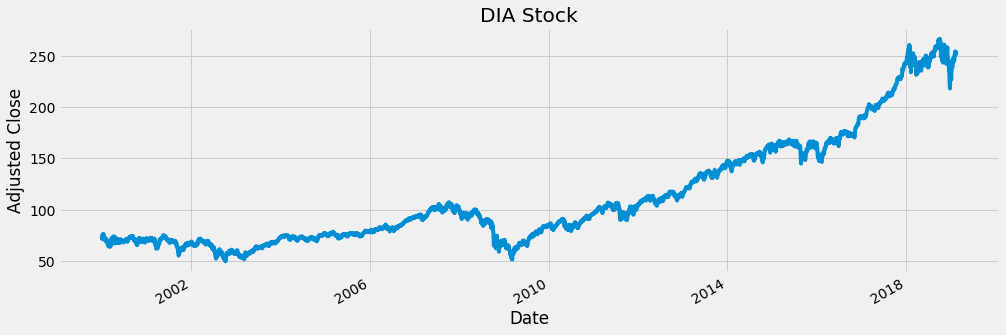

In [23]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
df[TICKER].plot(grid=True)
plt.ylabel('Adjusted Close')
plt.title('%s Stock' % TICKER);
plt.savefig('Stock_Graph1.png')

In [24]:
#Fixing an Index

# data.index = data.Date
# data.drop('Date', axis=1, inplace=True)

data.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-04',
               '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08',
               '2019-02-11', '2019-02-12'],
              dtype='datetime64[ns]', name='Date', length=4808, freq=None)

Date
2000-01-03    0.000000
2000-01-04   -2.435493
2000-01-05    0.927361
2000-01-06    0.366791
2000-01-07    2.445732
Name: Delta, dtype: float64

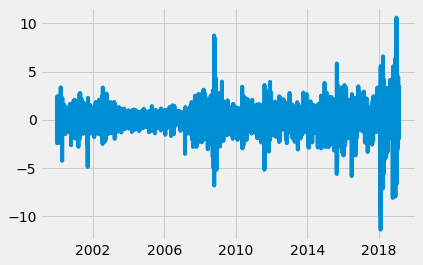

In [25]:
#Calculating deltas. 

data['Delta'] = np.append(np.array([0]), np.diff(data[TICKER].values))
plt.plot(data['Delta'])
plt.savefig('RawDIASignal.png')
data['Delta'].head()

In [26]:
#(Fast Fourier Transform)

superposition = np.fft.fft(data['Delta'].values)
list(superposition)[:5]

[(180.50662231445312+0j),
 (38.64494289694496+92.31836554546862j),
 (-28.490093982171693+37.983959122981304j),
 (32.35308559536632+104.20656063352234j),
 (-25.5302078431465+29.81800777342615j)]

In [27]:
#________________________________________________
#Finding Theta. Been a while since Complex Analysis so reformulating.
#(Lazy Latex. Only using \ for special characters. Ignoring traditional curly brackets.)
#(Also ignoring equivalency symbols in favor of implied symbols. Too tired to think through doublesidedness atm.)

#Assume that z = x + iy and that P = tan^(-1)(x + iy)
#=> P = tan(z)
#=> tan(P) = z
#=> sin(P) = (e^(iP) - e^(-iP))/(2i) and cos(P) = (e^(iP) + e^(-iP))/2
#=> tan(P) = sin(P)/cos(P) = (e^(iP) - e^(-iP))/(2i) * 2/(e^(iP)+ e^(-iP)) = (e^(iP) - e^(-iP))/(i(e^(iP) + e^(-iP)))
#=> Fix Q = e^(iP) such that 1/Q = e^(-iP)

#Then z = tan(P) => z = (Q-1/Q)/(i(Q+1/Q))
#=> iz = (Q^2 - 1)/(Q^2 + 1) 
#=> iz (Q^2 + 1) = (Q^2 - 1)
#=> -z(Q^2 + 1) = (Q^2 -1)i
#=> -zQ^2 - z = iQ^2 - i
#=> Q^2(-z - i) = z - i
#=> Q^2 = (z - i) / (-z - i)
#=> e^(2iP) = (z - i) / (-z - i) (multiply by conjugate here if the form looks funny to you)
#=> P = 1/(2i) * ln (z-i/(-z - i))
#=> e^(x + iy) = e^x * cos y + i * e^x * sin y
#=> e(ln(z)) = ln |z| = ln ((Re(z)^2 + Im(z)^2))^(1/2) = (1/2) ln (Re(z)^2 + Im(z)^2)

#=> tan^(-1)( Im(z)/Re(z) ) + 2n * \pi for all Re(z) > 0              

#We've found the relevant angle at which we obtain z.

data['Theta'] = np.arctan(superposition.imag/superposition.real)
data['Theta'].head()
#________________________________________________


Date
2000-01-03    0.000000
2000-01-04    1.174355
2000-01-05   -0.927259
2000-01-06    1.269761
2000-01-07   -0.862713
Name: Theta, dtype: float64

In [45]:
data['Frequency'] = np.fft.fftfreq(superposition.size, d=1)

In [29]:
ValueCount = len(data)
CountHalf = ValueCount / 2

data['Amplitude'] = np.sqrt(superposition.real**2 + superposition.imag**2)/CountHalf

data.head()
data.to_csv("Signal_Data.csv", encoding='utf-8')

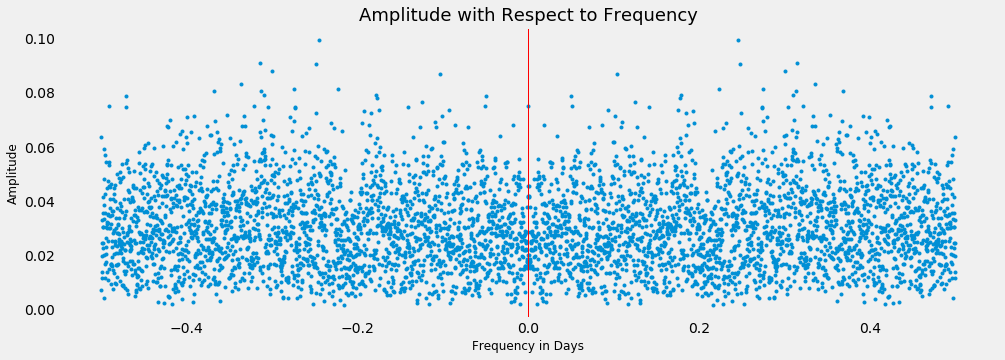

In [30]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
plt.plot(data['Frequency'], data['Amplitude'].values, '.')

#Fourier Mirror
plt.axvline(x=0, ymin=0, ymax = 1, linewidth=1, color='r')

plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency in Days', fontsize=12)
plt.title('Amplitude with Respect to Frequency', fontsize=18)
plt.grid()
plt.savefig('AmplitudeVsFreq2.png')

In [31]:
AverageAmplitude = data['Amplitude'].mean()
StandardDevAmplitude = data['Amplitude'].std()
ThreeSigmasOverMean = data['Amplitude'] > (3*StandardDevAmplitude + AverageAmplitude) 
PositiveFrequencies = data['Frequency'] > 0
SomeSigmas = data['Amplitude'] > (0.78*StandardDevAmplitude + AverageAmplitude)

In [32]:
#Filtration

Amp = data[SomeSigmas & PositiveFrequencies]['Amplitude']
Freq = data[SomeSigmas & PositiveFrequencies]['Frequency']
Thet = data[SomeSigmas & PositiveFrequencies]['Theta']

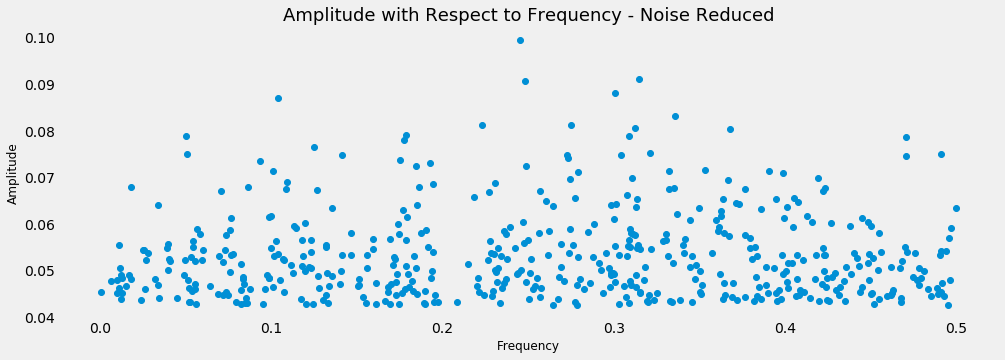

In [33]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
plt.plot(Freq, Amp, 'o')
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.title('Amplitude with Respect to Frequency - Noise Reduced', fontsize=18)
plt.grid();
plt.savefig('FilteredAmpVsFreqNew.png')

In [34]:
data[PositiveFrequencies].count()

DIA          2403
Delta        2403
Theta        2403
Frequency    2403
Amplitude    2403
dtype: int64

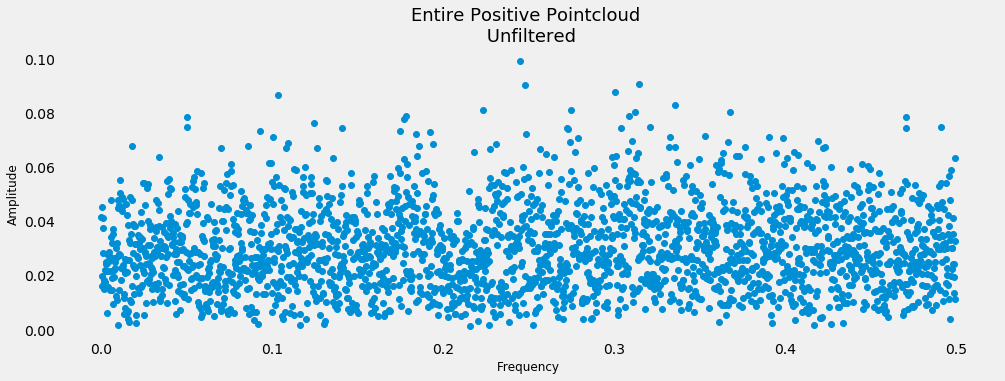

In [35]:
# Amp0 = data[PositiveFrequencies]['Amplitude']
# Freq0 = data[PositiveFrequencies]['Frequency']
# Thet0 = data[PositiveFrequencies]['Theta']

plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
plt.plot(Freq0, Amp0, 'o')
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.title('Entire Positive Pointcloud \n Unfiltered', fontsize=18)
plt.grid();
plt.savefig('Timeframe0.png')

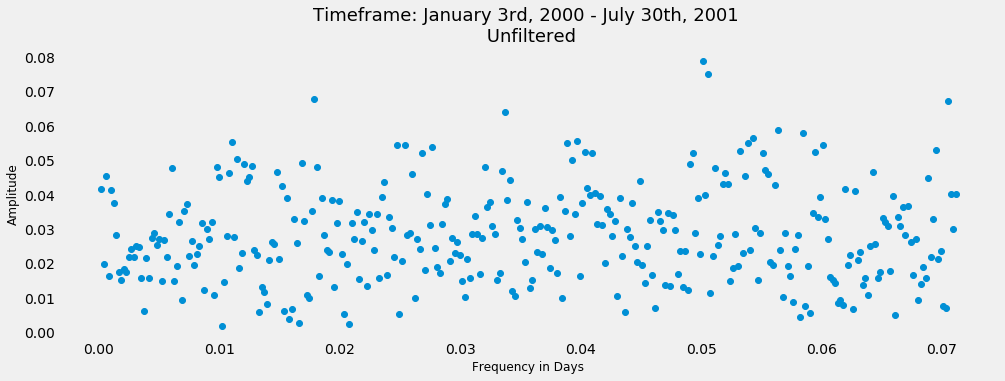

In [37]:
Amp1 = data[PositiveFrequencies]['Amplitude'][0:342]
Freq1 = data[PositiveFrequencies]['Frequency'][0:342]
Thet1 = data[PositiveFrequencies]['Theta'][0:342]

plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
plt.plot(Freq1, Amp1, 'o')
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency in Days', fontsize=12)
plt.title('Timeframe: January 3rd, 2000 - July 30th, 2001 \n Unfiltered', fontsize=18)
plt.grid();
plt.savefig('Timeframe1.png')

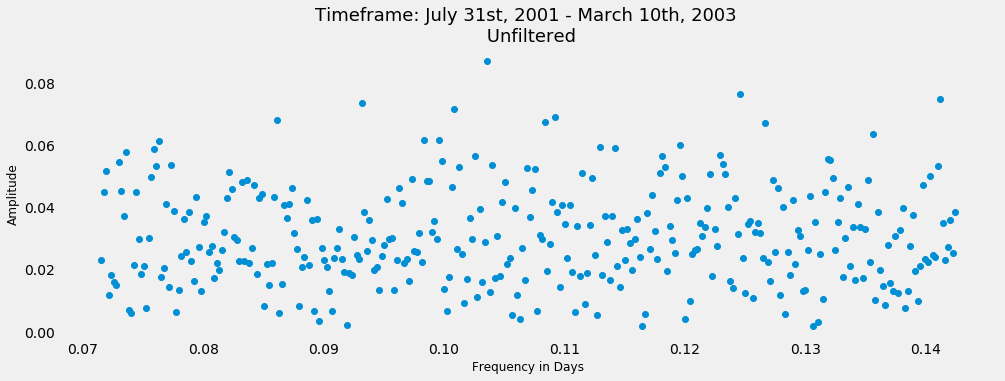

In [38]:
Amp1 = data[PositiveFrequencies]['Amplitude'][343:685]
Freq1 = data[PositiveFrequencies]['Frequency'][343:685]
Thet1 = data[PositiveFrequencies]['Theta'][343:685]

plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
plt.plot(Freq1, Amp1, 'o')
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency in Days', fontsize=12)
plt.title('Timeframe: July 31st, 2001 - March 10th, 2003 \n Unfiltered', fontsize=18)
plt.grid();
plt.savefig('Timeframe2.png')

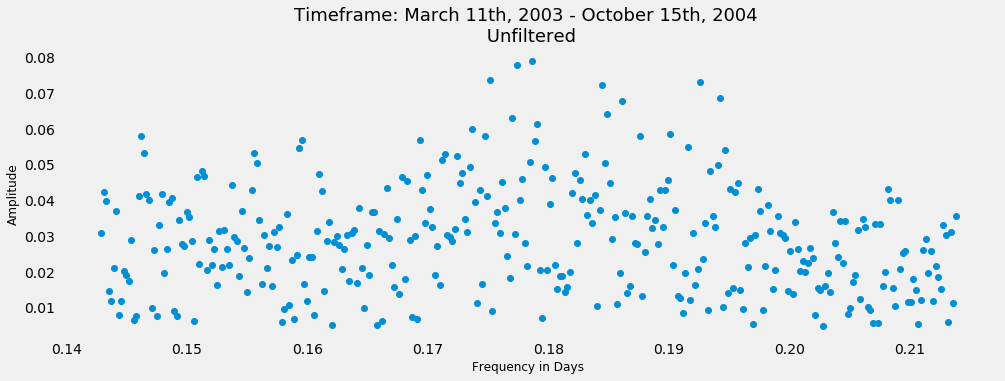

In [39]:
Amp1 = data[PositiveFrequencies]['Amplitude'][686:1028]
Freq1 = data[PositiveFrequencies]['Frequency'][686:1028]
Thet1 = data[PositiveFrequencies]['Theta'][686:1028]

plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
plt.plot(Freq1, Amp1, 'o')
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency in Days', fontsize=12)
plt.title('Timeframe: March 11th, 2003 - October 15th, 2004 \n Unfiltered', fontsize=18)
plt.grid();
plt.savefig('Timeframe3.png')

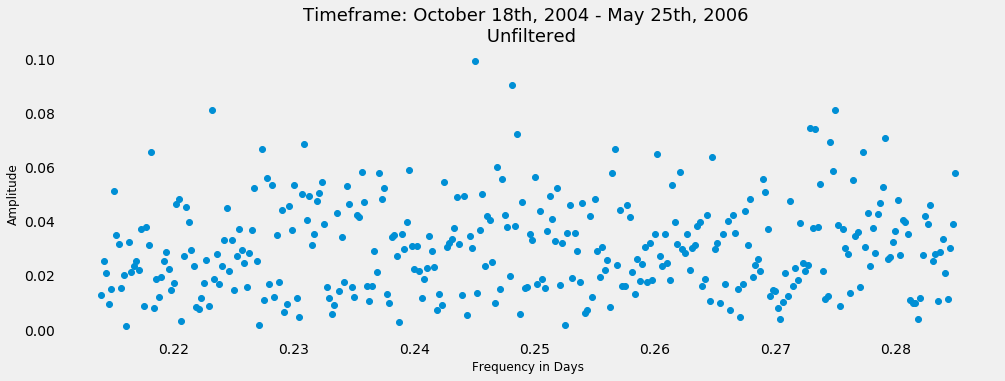

In [41]:
Amp1 = data[PositiveFrequencies]['Amplitude'][1028:1370]
Freq1 = data[PositiveFrequencies]['Frequency'][1028:1370]
Thet1 = data[PositiveFrequencies]['Theta'][1028:1370]

plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
plt.plot(Freq1, Amp1, 'o')
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency in Days', fontsize=12)
plt.title('Timeframe: October 18th, 2004 - May 25th, 2006 \n Unfiltered', fontsize=18)
plt.grid();
plt.savefig('Timeframe4.png')

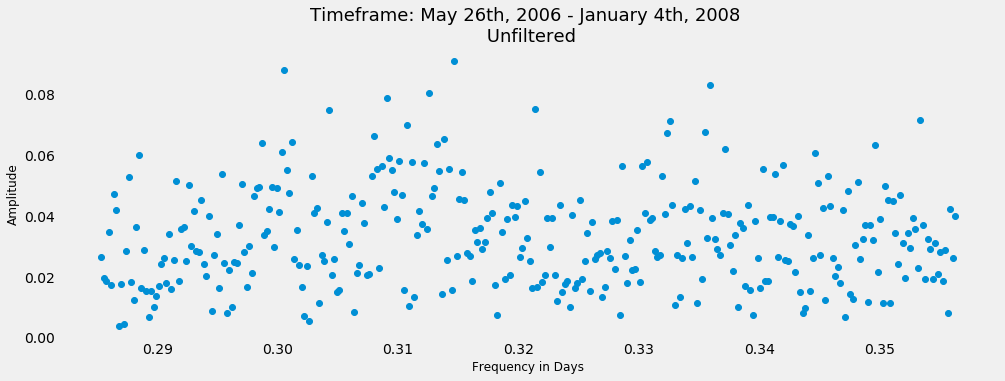

In [42]:
Amp1 = data[PositiveFrequencies]['Amplitude'][1371:1713]
Freq1 = data[PositiveFrequencies]['Frequency'][1371:1713]
Thet1 = data[PositiveFrequencies]['Theta'][1371:1713]

plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
plt.plot(Freq1, Amp1, 'o')
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency in Days', fontsize=12)
plt.title('Timeframe: May 26th, 2006 - January 4th, 2008 \n Unfiltered', fontsize=18)
plt.grid();
plt.savefig('Timeframe5.png')

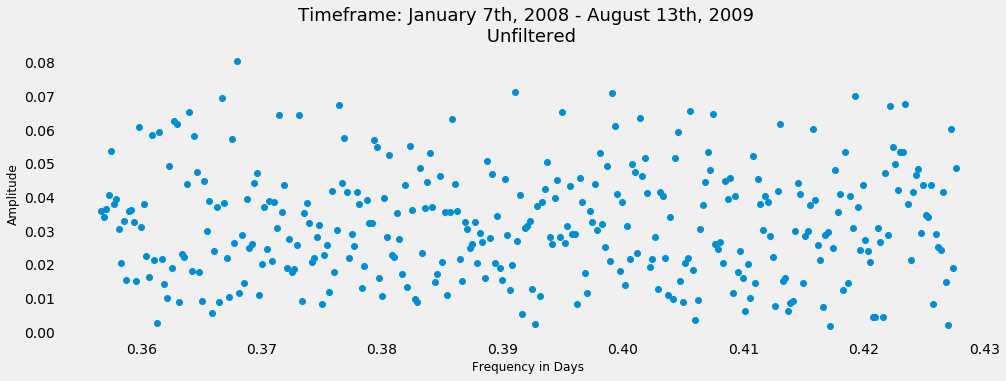

In [43]:
Amp1 = data[PositiveFrequencies]['Amplitude'][1714:2056]
Freq1 = data[PositiveFrequencies]['Frequency'][1714:2056]
Thet1 = data[PositiveFrequencies]['Theta'][1714:2056]

plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
plt.plot(Freq1, Amp1, 'o')
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency in Days', fontsize=12)
plt.title('Timeframe: January 7th, 2008 - August 13th, 2009 \n Unfiltered', fontsize=18)
plt.grid();
plt.savefig('Timeframe6.png')

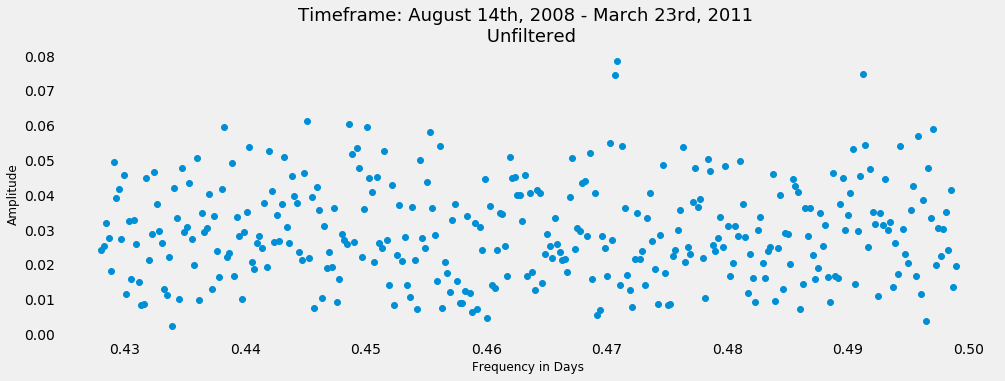

In [44]:
Amp1 = data[PositiveFrequencies]['Amplitude'][2057:2399]
Freq1 = data[PositiveFrequencies]['Frequency'][2057:2399]
Thet1 = data[PositiveFrequencies]['Theta'][2057:2399]

plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
plt.plot(Freq1, Amp1, 'o')
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Frequency in Days', fontsize=12)
plt.title('Timeframe: August 14th, 2008 - March 23rd, 2011 \n Unfiltered', fontsize=18)
plt.grid();
plt.savefig('Timeframe7.png')

In [17]:
#Delta Time to Start Time  
Start = data[TICKER][0]
Regress = Start + np.cumsum(DeltaSequence)

Regress_df = pd.DataFrame(data=Regress.flatten())

In [18]:
data.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31',
               '2019-02-01', '2019-02-04', '2019-02-05', '2019-02-06',
               '2019-02-07', '2019-02-08'],
              dtype='datetime64[ns]', name='Date', length=4806, freq=None)

In [19]:
Regress_df['Date'] = data.index
Regression_df = Regress_df.set_index('Date')

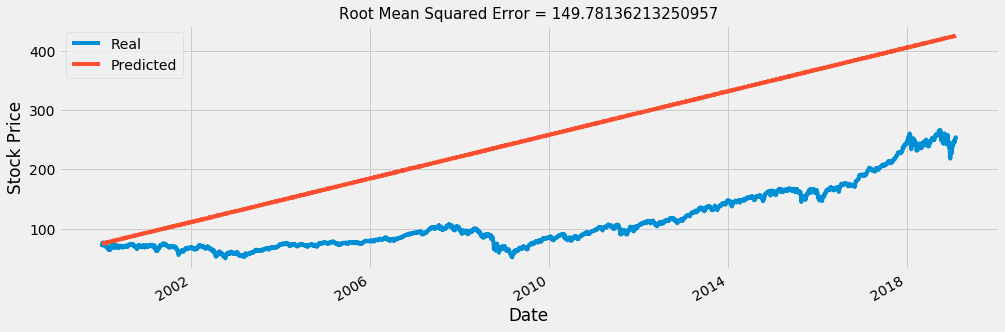

In [20]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
data[TICKER].plot(grid=True)
Regression_df[0].plot(grid=True)
plt.ylabel('Stock Price')
plt.legend(['Real','Predicted']);

RMS = np.sqrt(np.mean((data[TICKER].values - Regress)**2))

plt.title('Root Mean Squared Error = ' + str(RMS), fontsize=15);
plt.savefig('VanillaRegression4.png')

In [21]:
def Optimizer(std_value):
    
    #Getting dominant values based on std_value
    MuAmp = data['Amplitude'].mean()
    StDevAmp = data['Amplitude'].std()
    AmpFilter = data['Amplitude'] > (std_value*StDevAmp + MuAmp) 
    PositivityFreq = data['Frequency'] > 0
    Amps = data[AmpFilter & PositivityFreq]['Amplitude']
    Freqs = data[AmpFilter & PositivityFreq]['Frequency']
    Thets = data[AmpFilter & PositivityFreq]['Theta']
    
    #Calculating Regression Delta
    RegressionDeltas = 0
    for i in range(len(Thets)):
        Shift = Thets[i]
        RegressionDeltas += Amps[i] * np.cos(i * np.array(range(len(data))) + Shift)

    #Converting Delta Time to Time at start value of real data    
    StartValue = data[TICKER][0]
    Regressor = StartValue - np.cumsum(RegressionDeltas)
    
    #Calculating RMSE
    RMS = np.sqrt(np.mean((data[TICKER].values - Regressor)**2))
    
    if np.isnan(RMS):
        RMS = 10000000000000
    
    return RMS

In [22]:
StandardDevValues = []
RMSValues = []

for i in np.linspace(0,2,20):
    StandardDevValues.append(i)
    RMSValues.append(Optimizer(i))

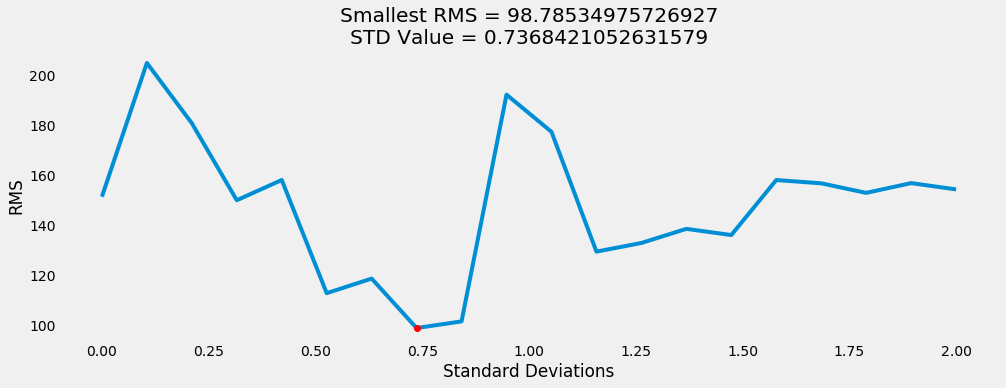

In [23]:
plt.style.use('fivethirtyeight')

Epsilon = np.array(RMSValues).argmin()
MinStDev = StandardDevValues[Epsilon]
MinRMS = RMSValues[Epsilon]

plt.figure(figsize=(15,5))
plt.plot(StandardDevValues, RMSValues)
plt.plot(MinStDev, MinRMS, 'ro')
plt.ylabel('RMS')
plt.xlabel('Standard Deviations')
plt.title('Smallest RMS = '+str(MinRMS)+'\nSTD Value = '+str(MinStDev))
plt.grid()
plt.savefig('IdealSigmaFilter5.png')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.


[{'Days': '2000-01-03',
  'Predicted': 91.9896496181,
  '_id': ObjectId('5c610f8fabd5b644d09e3da4')},
 {'Days': '2000-01-04',
  'Predicted': 91.7995218918,
  '_id': ObjectId('5c610f8fabd5b644d09e3da5')},
 {'Days': '2000-01-05',
  'Predicted': 92.44177073,
  '_id': ObjectId('5c610f8fabd5b644d09e3da6')},
 {'Days': '2000-01-06',
  'Predicted': 92.2259830083,
  '_id': ObjectId('5c610f8fabd5b644d09e3da7')},
 {'Days': '2000-01-07',
  'Predicted': 91.3281836435,
  '_id': ObjectId('5c610f8fabd5b644d09e3da8')},
 {'Days': '2000-01-10',
  'Predicted': 90.7909814805,
  '_id': ObjectId('5c610f8fabd5b644d09e3da9')},
 {'Days': '2000-01-11',
  'Predicted': 89.5241626265,
  '_id': ObjectId('5c610f8fabd5b644d09e3daa')},
 {'Days': '2000-01-12',
  'Predicted': 89.961395106,
  '_id': ObjectId('5c610f8fabd5b644d09e3dab')},
 {'Days': '2000-01-13',
  'Predicted': 90.63502296,
  '_id': ObjectId('5c610f8fabd5b644d09e3dac')},
 {'Days': '2000-01-14',
  'Predicted': 90.0385706175,
  '_id': ObjectId('5c610f8fabd5b6

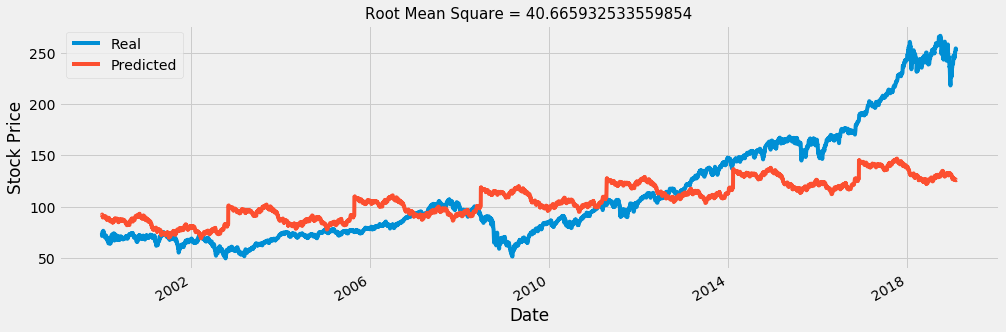

In [24]:
#Getting dominant values based on std_value
MeanAmp = data['Amplitude'].mean()
StDAmp = data['Amplitude'].std()

AmpFiltered = data['Amplitude'] > (MinStDev*StDAmp + MeanAmp) 
FreqPositive = data['Frequency'] > 0
Ampz = data[AmpFiltered & FreqPositive]['Amplitude']
Freqz = data[AmpFiltered & FreqPositive]['Frequency']
Thetz = data[AmpFiltered & FreqPositive]['Theta']

#Calculating Regression Delta
RegressedDeltas = 0
for i in range(len(Thetz)):
    Shift = Thetz[i]
    RegressedDeltas += Ampz[i] * np.cos(i * np.array(range(len(data))) + Shift)

#Converting Delta Time to Time at start value of real data    
Starter = data[TICKER][0]
Regresss = Starter + np.cumsum(RegressedDeltas)
Regresss_df = pd.DataFrame(data=Regresss.flatten())

Regresss_df['Date'] = data.index
Regressed_df = Regresss_df.set_index('Date')
df=Regressed_df.rename(columns = {'Date':'Days'})
# df['Days']=data.index
dff=df.reset_index()

dff = dff.rename(columns = {0 : 'Predicted','Date':'Days'})

# data['Days'] = dff['Days']

# data.Days = data.Days.astype(str)
# data
DF=data.rename(columns = {TICKER : 'Real Values'})
df_c = pd.concat([DF.reset_index(drop=True), dff['Days']], axis=1)
df_d=df_c.drop(['Delta', 'Theta', 'Frequency', 'Amplitude'], axis=1)
df_e=df_d.dropna(axis='columns')
df_e
# #dff.head()
# # dff.index
# #dff.head()
dff.Days = dff.Days.astype(str)
df_e.Days = df_e.Days.astype(str)

records = json.loads(dff.to_json(orient='records'))
records2 = json.loads(df_e.to_json(orient='records'))

conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

client.db.DSP.drop()
client.db.DSP.insert(records)

client.db.TickTock.drop()
client.db.TickTock.insert(records2)
# # Regressed_df.to_csv('DSP.csv', encoding='utf-8', index=True)
# # data[TICKER].to_csv('TickTock.csv', encoding='utf-8', index=True)

plt.figure(figsize=(15,5))
data[TICKER].plot(grid=True)
Regressed_df[0].plot(grid=True)
plt.ylabel('Stock Price')
plt.legend(['Real','Predicted']);

RootMeanSquare = np.sqrt(np.mean((data[TICKER].values - Regresss)**2))

plt.title('Root Mean Square = ' + str(RootMeanSquare), fontsize=15);
# plt.savefig('SignalledRegression6.png')
records

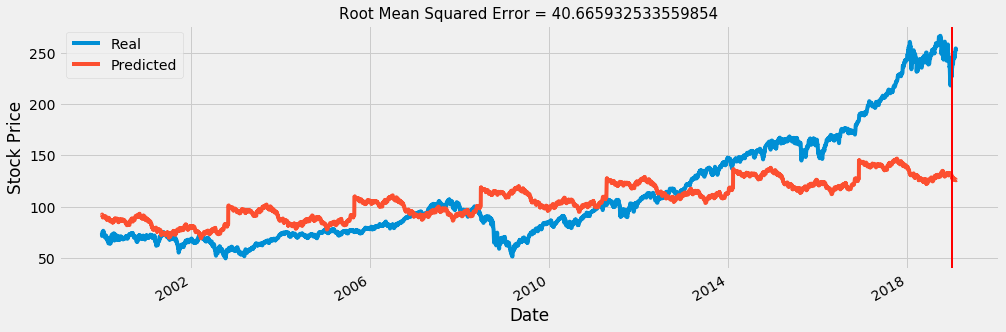

In [25]:
#10 Year Prediction
MeanAmp = data['Amplitude'].mean()
StDAmp = data['Amplitude'].std()
AmpFiltered = data['Amplitude'] > (MinStDev*StDAmp + MeanAmp) 
FreqPositive = data['Frequency'] > 0
Ampz = data[AmpFiltered & FreqPositive]['Amplitude']
Freqz = data[AmpFiltered & FreqPositive]['Frequency']
Thetz = data[AmpFiltered & FreqPositive]['Theta']

RegressorDelt = 0
for i in range(len(Thetz)):
    Shift = Thetz[i]
    RegressorDelt += Ampz[i] * np.cos(i * np.array(range(len(data))) + Shift)

#Converting Delta Time to Time at start value of real data    
Started = data[TICKER][0]
Regrezz = Started + np.cumsum(RegressorDelt)
Regrezz_df = pd.DataFrame(data=Regrezz.flatten())

Regrezz_df['Date'] = data.index
Regrezzed_df = Regrezz_df.set_index('Date')


plt.style.use('fivethirtyeight')

plt.figure(figsize=(15,5))
data[TICKER].plot(grid=True)
Regrezzed_df[0].plot(grid=True)
plt.ylabel('Stock Price')
plt.legend(['Real','Predicted'])

plt.axvline(x='2019-01-03', ymin=0, ymax = 1, linewidth=2, color='r')

RMSp = np.sqrt(np.mean((data[TICKER].values - Regrezz)**2))

plt.title('Root Mean Squared Error = ' + str(RMSp), fontsize=15);
plt.savefig('19YearPrediction7.png')